In [1]:
import os
import numpy as np
import h5py as h5
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import ConnectionPatch, FancyArrowPatch
from datetime import datetime
import argparse
import pdb
from functools import partial
from copy import deepcopy
from tqdm.notebook import tqdm
import pickle as pkl

import jax
import jax.numpy as jnp
import equinox as eqx
import optax

import samplers
import models
import main
import main_utils
import opto
import coopetition_model_solver
import plot_utils
import visualize_runs

%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
root_folder = '/path/to/save'
base_folder = f'{root_folder}/runs'
save_folder = f'{root_folder}/coopetition_figures'
os.makedirs(save_folder, exist_ok=True)
os.makedirs(f'{save_folder}/appendix', exist_ok=True)
main_run = 'main'

# Section 3: Reproducing transience

Subfigures a and c are diagrams. Subfigure b is made below:

In [4]:
evaluator_info = {'train_eval': {'label': 'Train', 'c': 'k'},
                  'icl': {'label': 'ICL eval', 'c': '#1f78b4'},
                  'iwl_copy_avail': {'label': 'CIWL eval', 'c': '#33a02c'},
                  'flip_icl': {'label': 'Flip eval', 'c': '#e31a1c'}
                 }

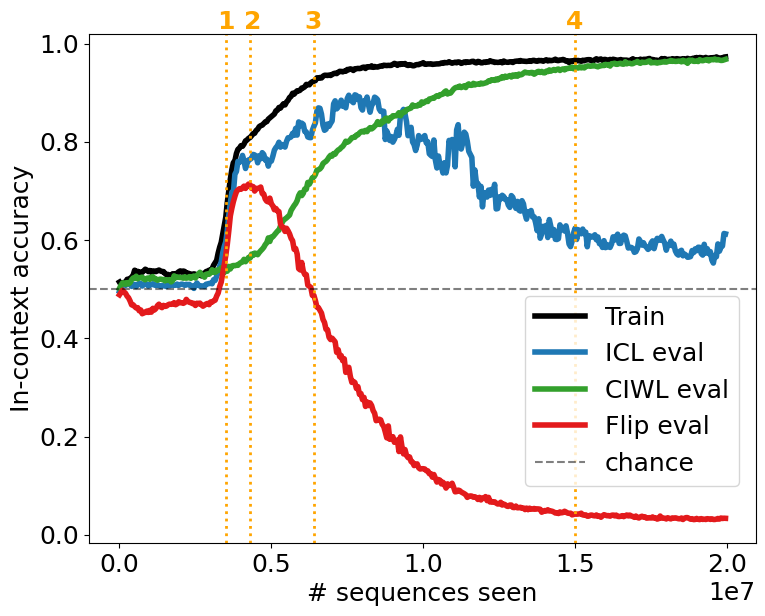

In [5]:
f = h5.File(f'{base_folder}/{main_run}/log.h5', 'r')

matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(8,6.5)
lw=4
metric='in_context_acc'

raw_x = f['eval_iter'][:]
mask = raw_x < 2e7
for e in evaluator_info:
    axs.plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, **evaluator_info[e])
axs.axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)

annot_color = 'orange'
annots = {0.35e7: {'text': '1', 'offset': -0.03e7}, #-0.07e7}, 
          0.43e7: {'text': '2', 'offset': -0.02e7}, #0.01e7}, 
          0.64e7: {'text': '3', 'offset': -0.03e7}, #0.01e7}, 
          1.5e7: {'text': '4', 'offset': -0.03e7}, #-0.07e7}
         }
for loc in annots:
    axs.axvline(loc, c = annot_color, ls='dotted', lw=2)
    axs.text(loc+annots[loc]['offset'], 1.03, annots[loc]['text'], c=annot_color, weight='bold')

axs.legend(bbox_to_anchor=(0.635, 0.51), loc='upper left')
axs.set_ylabel("In-context accuracy")
axs.set_xlabel("# sequences seen")
plt.tight_layout()

fig.savefig(f'{save_folder}/figure_1b.pdf')
f.close()

# Section 4: The CIWL mechanism

We start by loading in eval data + model checkpoint.

In [6]:
# Get eval data
eval_h5 = h5.File(f'{root_folder}/runs/default_eval/eval_data.h5','r')

eval_data = dict()
for k in eval_h5:
    eval_data[k] = dict()
    for s in eval_h5[k].keys():
        eval_data[k][s] = jnp.array(eval_h5[k][s])
    if 'correct_ind' not in eval_data[k]:
        print("Assigning correct_ind info posthoc", k)
        match_output = eval_data[k]['labels'][:, :-1] == eval_data[k]['labels'][:, -1][:, None]
        eval_data[k]['correct_ind'] = jnp.where(jnp.sum(match_output, axis=1) > 0, jnp.argmax(match_output, axis=1), -1)

Assigning correct_ind info posthoc flip_icl
Assigning correct_ind info posthoc icl
Assigning correct_ind info posthoc iwl_copy_avail
Assigning correct_ind info posthoc pure_iwl
Assigning correct_ind info posthoc train_eval


In [7]:
# Setup model checkpoint load code
opts = main_utils.get_opts_from_json_file(f'{base_folder}/{main_run}/config.json')

# Hardcode data shape to avoid loading in.
model = main_utils.get_model_from_opts(opts, (512, ))
fwd_fn_from_train = opto.make_fn_from_opts(opts)

print("model output shape", model.unembed.weight.shape)
opt_state = main_utils.get_optimizer_from_opts(opts).init(eqx.filter(model, eqx.is_array))

ckpt_fmt = {'iter': -1, 
            'seeds': {'eval_model_seed': jax.random.PRNGKey(0),
                      'train_data_seed': jax.random.PRNGKey(0),
                      'train_model_seed': jax.random.PRNGKey(0)}, 
            'opt_state': opt_state,
            'model': model}

model output shape (12800, 64)


In [8]:
# Get final checkpoint
final_ckpt_fname = '/'.join([base_folder, main_run, 'checkpoints', '{}.eqx'.format(str(int(64e6)).zfill(11))])
final_ckpt = eqx.tree_deserialise_leaves(final_ckpt_fname, ckpt_fmt)

Next, we make a batched forward function to enable ablations

In [9]:
parser = argparse.ArgumentParser()
opto.add_args_to_parser(parser)
base_opts = parser.parse_args(args=[])
print(base_opts)
batch_size = 1024

Namespace(opto_specific_fn=None, opto_induction_heads=None, opto_induction_head_strength=1.0, opto_match_heads=None, opto_match_head_temperature=0.0, opto_prev_token_heads=None, opto_prev_token_head_strength=1.0, opto_prev_token_only_label=False, opto_disallow_prev_token_heads=None, opto_disallow_prev_token_only_label=False, opto_ablate_heads=None, opto_ablate_embedding=False, opto_perfect_copy_from_head_pattern=None, opto_set_head_temperature=None, opto_final_layer_silence_non_label_attn=None, opto_preserve_patterns=False, opto_preserve_values=False, opto_preserve_queries=False, opto_preserve_keys=False, opto_graft_in_model_ckpt=None, opto_graft_in_model_cfg=None, opto_graft_in_model_till_layer=None, opto_graft_out_model_ckpt=None, opto_graft_out_model_cfg=None, opto_graft_out_model_from_layer=None)


In [10]:
def make_forward_fn_ic_only(options, default_fn=opto.default_model_fwd_fn):
    '''
    Makes an opto-ified forward_fn that returns just in-context metrics
    '''
    call_fn = opto.make_fn_from_opts(options, default_fn=default_fn)

    def forward_fn(model, x, y, key):
        keys = jax.random.split(key, x.shape[0])
        all_activations = jax.vmap(partial(call_fn, model=model))(x=x, y=y, key=keys)
        query_ce = main.ce(all_activations['out'][:, -1, :], y[:, -1])

        in_context_mask = jnp.sum(jax.nn.one_hot(y[:, :-1], all_activations['out'].shape[-1]), axis=1) > 0
        in_context_pred_y = in_context_mask*all_activations['out'][:, -1, :] - (1-in_context_mask)*1e20
        fsl_loss = main.ce(in_context_pred_y, y[:, -1])
        fsl_output_prob = jnp.einsum('bc,bc->b', 
                                    jax.nn.softmax(in_context_pred_y), 
                                    jax.nn.one_hot(y[:, -1], in_context_pred_y.shape[-1]))
        fsl_output_acc = (jnp.argmax(in_context_pred_y, axis=-1) == y[:,-1])

        return {'in_context_loss': fsl_loss,
                'in_context_prob': fsl_output_prob,
                'in_context_acc': fsl_output_acc,
                'loss': query_ce}

    return eqx.filter_jit(forward_fn)

#### Note, throughout this notebook, we'll use L0/L1 to refer to Layers 1 and 2, due to 0-indexing in code. We'll also use IWL copy avail and CIWL interchangeably (as the former is an older name that was used).

### Result 1: L0 does not contribute meaningfully to output
First, we make:
1. A default forward function (for baseline)
2. A forward function with L0 ablated, but queries, keys, and values preserved in L1

In [11]:
temp_opts = deepcopy(base_opts)
default_fn = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

In [12]:
temp_opts = deepcopy(base_opts)
temp_opts.opto_ablate_heads = ['0:{}'.format(lay) for lay in range(8)]
temp_opts.opto_preserve_queries = True
temp_opts.opto_preserve_keys = True
temp_opts.opto_preserve_values = True
l0_output_ablation_fn = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...


In [13]:
l0_output_ablation_results = dict()
for name, fn in zip(['default', 'l0_output_ablation'], [default_fn, l0_output_ablation_fn]):
    for e in ['train_eval', 'iwl_copy_avail', 'flip_icl']:
        l0_output_ablation_results.setdefault(name, dict())[e] = fn(final_ckpt['model'], 
                                                                    eval_data[e]['examples'], 
                                                                    eval_data[e]['labels'], 
                                                                    key=jax.random.PRNGKey(0))

In [14]:
for e in l0_output_ablation_results[name]:
    for metric in ['in_context_acc']:
        for name in l0_output_ablation_results:
            print(name, e, metric, jnp.mean(l0_output_ablation_results[name][e][metric]))

default train_eval in_context_acc 0.9862
l0_output_ablation train_eval in_context_acc 0.9852
default iwl_copy_avail in_context_acc 0.9874
l0_output_ablation iwl_copy_avail in_context_acc 0.9848
default flip_icl in_context_acc 0.014599999
l0_output_ablation flip_icl in_context_acc 0.0178


Recall that Flip ICL = 0 means perfect CIWL strategy, so really the last two number should be viewed as one minus (so 98.54% vs 98.22%).

Next, we want to look at the actual activations, which we will plot as a heatmap for each Layer 2 head -> token from the query

In [15]:
default_fn_with_act = main.make_batched_fn(visualize_runs.make_forward_fn(base_opts, default_fn=fwd_fn_from_train), batch_size)

In [16]:
default_fn_with_act_results = dict()
default_fn_with_act_results['iwl_copy_avail'] = default_fn_with_act(final_ckpt['model'], 
                                                                      eval_data['iwl_copy_avail']['examples'], 
                                                                      eval_data['iwl_copy_avail']['labels'], 
                                                                      key=jax.random.PRNGKey(0))

In [17]:
num_seqs = default_fn_with_act_results['iwl_copy_avail']['activations'].shape[0]

In [18]:
average_attn_per_head_ind2 = jnp.mean(default_fn_with_act_results['iwl_copy_avail']['activations'][(1-eval_data['iwl_copy_avail']['correct_ind']).astype(bool), 1, :, -1, :], axis=0)
average_attn_per_head_ind4 = jnp.mean(default_fn_with_act_results['iwl_copy_avail']['activations'][eval_data['iwl_copy_avail']['correct_ind'].astype(bool), 1, :, -1, :], axis=0)

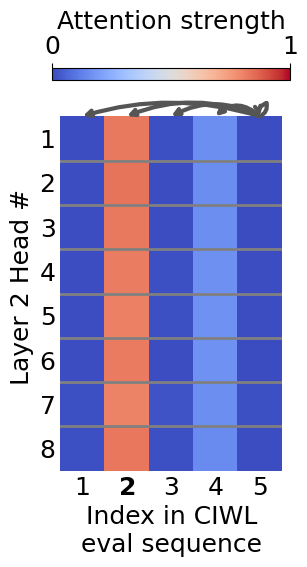

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(4,6)

im = ax.imshow(average_attn_per_head_ind2, cmap='coolwarm', vmin=0, vmax=1)

for l in ['top', 'right', 'bottom', 'left']:
    ax.spines[l].set_visible(False)

for i in range(1,8):
    ax.axhline(i-0.5, linestyle='-', c='gray', lw=2)

arrow_props = dict(
    color='#555555',
    alpha=1,
    linewidth=3
)

heights = [0.15, 0.2, 0.26, 0.45, 1.5]

# Create arrows from the top of the query column to inserted label column
for i in range(5):
    con = ConnectionPatch(
        xyA=(4, -0.5),  # Start from top of query column
        xyB=(i, -0.5),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(heights[i]),
        arrowstyle='->',
        **arrow_props
    )
    ax.add_artist(con)


height = 0.4
con = ConnectionPatch(
        xyA=(4, -0.5),  # Start from top of query column
        xyB=(4.15, -0.8),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(height),
        arrowstyle='-',
        **arrow_props
    )
ax.add_artist(con)

con = ConnectionPatch(
        xyA=(4.15, -0.8),  # Start from top of query column
        xyB=(4, -0.5),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(height),
        arrowstyle='->',
        **arrow_props
    )
ax.add_artist(con)

fig.colorbar(im, orientation='horizontal', label='Attention strength', 
             location='top', shrink=0.7, ticks=[0,1])

ax.tick_params(axis='both', length=0)
ax.set_yticks(range(8), range(1, 9))
ax.set_ylabel('Layer 2 Head #')
ax.set_ylim(7.5, -0.8)
ax.set_xticks(range(5), [(r'$\bf{2}$' if i == 2 else str(i)) for i in range(1,6)])
ax.set_xlabel('Index in CIWL\neval sequence')

plt.tight_layout()
fig.savefig(f'{save_folder}/figure_2a.pdf')

We quickly make the corresponding appendix figure here

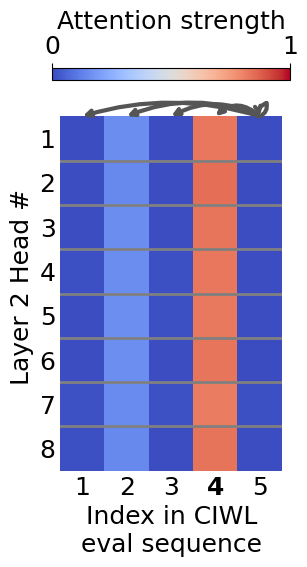

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(4,6)

im = ax.imshow(average_attn_per_head_ind4, cmap='coolwarm', vmin=0, vmax=1)

for l in ['top', 'right', 'bottom', 'left']:
    ax.spines[l].set_visible(False)

for i in range(1,8):
    ax.axhline(i-0.5, linestyle='-', c='gray', lw=2)

arrow_props = dict(
    color='#555555',
    alpha=1,
    linewidth=3
)

heights = [0.15, 0.2, 0.26, 0.45, 1.5]

# Create arrows from the top of the query column to inserted label column
for i in range(5):
    con = ConnectionPatch(
        xyA=(4, -0.5),  # Start from top of query column
        xyB=(i, -0.5),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(heights[i]),
        arrowstyle='->',
        **arrow_props
    )
    ax.add_artist(con)


height = 0.4
con = ConnectionPatch(
        xyA=(4, -0.5),  # Start from top of query column
        xyB=(4.15, -0.8),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(height),
        arrowstyle='-',
        **arrow_props
    )
ax.add_artist(con)

con = ConnectionPatch(
        xyA=(4.15, -0.8),  # Start from top of query column
        xyB=(4, -0.5),     # End at each row of inserted label column
        coordsA='data',
        coordsB='data',
        axesA=ax, axesB=ax,
        connectionstyle='arc3,rad={}'.format(height),
        arrowstyle='->',
        **arrow_props
    )
ax.add_artist(con)

fig.colorbar(im, orientation='horizontal', label='Attention strength', 
             location='top', shrink=0.7, ticks=[0,1])

ax.tick_params(axis='both', length=0)
ax.set_yticks(range(8), range(1, 9))
ax.set_ylabel('Layer 2 Head #')
ax.set_ylim(7.5, -0.8)
ax.set_xticks(range(5), [(r'$\bf{4}$' if i == 4 else str(i)) for i in range(1,6)])
ax.set_xlabel('Index in CIWL\neval sequence')

plt.tight_layout()
fig.savefig(f'{save_folder}/appendix/figure_2a_2.pdf')

Next, we make the figure demonstrating that each head is in fact copying.

In [21]:
skip_trigram_copying_fns = dict()
strengths = np.linspace(0, 1, 11)
for h in range(8):
    l1_heads = ['1:{}'.format(head) for head in range(8) if head != h] + ['0:{}'.format(head) for head in range(8)]
    temp_opts = deepcopy(base_opts)
    temp_opts.opto_ablate_heads = l1_heads
    temp_opts.opto_ablate_embedding = True
    temp_opts.opto_preserve_patterns = True
    temp_opts.opto_preserve_values = True
    skip_trigram_copying_fns['only_l1h{}'.format(h)] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)
    for s in strengths:
        temp_opts = deepcopy(base_opts)
        temp_opts.opto_ablate_heads = l1_heads
        temp_opts.opto_induction_heads = ['1:{}'.format(h)]
        temp_opts.opto_induction_head_strength = s
        temp_opts.opto_ablate_embedding = True
        temp_opts.opto_preserve_patterns = True
        temp_opts.opto_preserve_values = True
        skip_trigram_copying_fns['only_l1h{}_s{:.2f}'.format(h, s)] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being used...
Opto being u

In [22]:
skip_trigram_copying_results = dict()
for fn_name in tqdm(skip_trigram_copying_fns):
    skip_trigram_copying_results[fn_name] = skip_trigram_copying_fns[fn_name](final_ckpt['model'], 
                                                                                eval_data['iwl_copy_avail']['examples'], 
                                                                                eval_data['iwl_copy_avail']['labels'], 
                                                                                key=jax.random.PRNGKey(0))

  0%|          | 0/96 [00:00<?, ?it/s]

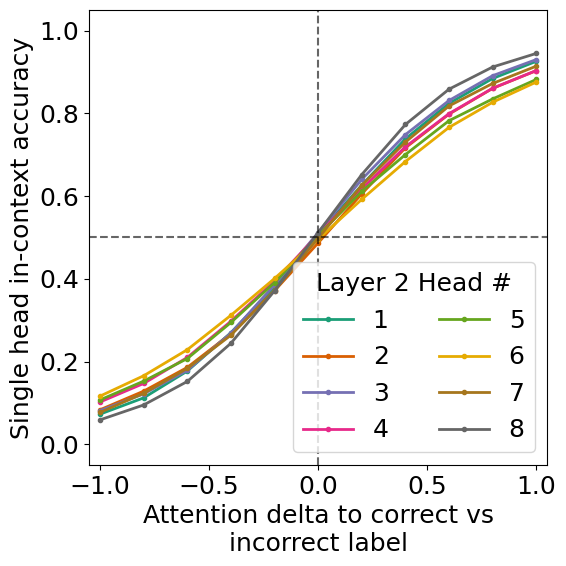

In [23]:
cmap = plt.get_cmap('Dark2')
fig, axs = plt.subplots()
fig.set_size_inches(6,6)
for h in range(8):
    axs.plot(strengths*2-1, [jnp.mean(skip_trigram_copying_results['only_l1h{}_s{:.2f}'.format(h, s)]['in_context_acc']) 
                             for s in strengths],
             marker='.', lw=2,
             c=cmap(h), label=h+1)

axs.legend(loc='lower right', title='Layer 2 Head #', ncol=2)
axs.axhline(0.5, c='k', ls='--', alpha=0.6)
axs.axvline(0, c='k', ls='--', alpha=0.6)
axs.set_xlim(-1.05, 1.05)
axs.set_ylim(-0.05, 1.05)
axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axs.set_ylabel('Single head in-context accuracy')
axs.set_xlabel('Attention delta to correct vs\nincorrect label')
plt.tight_layout()
fig.savefig(f'{save_folder}/figure_2b.pdf')

Demonstrating that there is significant K- and V- composition but not as much Q- composition

In [24]:
preserve_all_but_fns = dict()

temp_opts = deepcopy(base_opts)
temp_opts.opto_ablate_heads = ['0:{}'.format(lay) for lay in range(8)]
temp_opts.opto_preserve_keys = True
temp_opts.opto_preserve_values = True
preserve_all_but_fns['queries'] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

temp_opts = deepcopy(base_opts)
temp_opts.opto_ablate_heads = ['0:{}'.format(lay) for lay in range(8)]
temp_opts.opto_preserve_queries = True
temp_opts.opto_preserve_values = True
preserve_all_but_fns['keys'] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

temp_opts = deepcopy(base_opts)
temp_opts.opto_ablate_heads = ['0:{}'.format(lay) for lay in range(8)]
temp_opts.opto_preserve_keys = True
temp_opts.opto_preserve_queries = True
preserve_all_but_fns['values'] = main.make_batched_fn(make_forward_fn_ic_only(temp_opts, default_fn=fwd_fn_from_train), batch_size)

Opto being used...
Opto being used...
Opto being used...


In [25]:
preserve_all_but_results = dict()
for name in preserve_all_but_fns:
    for e in ['train_eval', 'iwl_copy_avail', 'flip_icl']:
        preserve_all_but_results.setdefault(name, dict())[e] = preserve_all_but_fns[name](final_ckpt['model'], 
                                                                                            eval_data[e]['examples'], 
                                                                                            eval_data[e]['labels'], 
                                                                                            key=jax.random.PRNGKey(0))

In [26]:
for e in preserve_all_but_results[name]:
    for metric in ['in_context_acc']:
        print('default', e, metric, jnp.mean(l0_output_ablation_results['default'][e][metric]))
        for name in preserve_all_but_results:
            print('preserve all but', name, e, metric, jnp.mean(preserve_all_but_results[name][e][metric]))

default train_eval in_context_acc 0.9862
preserve all but queries train_eval in_context_acc 0.95739996
preserve all but keys train_eval in_context_acc 0.5706
preserve all but values train_eval in_context_acc 0.59279996
default iwl_copy_avail in_context_acc 0.9874
preserve all but queries iwl_copy_avail in_context_acc 0.954
preserve all but keys iwl_copy_avail in_context_acc 0.5748
preserve all but values iwl_copy_avail in_context_acc 0.5864
default flip_icl in_context_acc 0.014599999
preserve all but queries flip_icl in_context_acc 0.046
preserve all but keys flip_icl in_context_acc 0.4466
preserve all but values flip_icl in_context_acc 0.39999998


# Section 5: Cooperative interactions between ICL and CIWL

## Section 5.1

We start by showing that induction heads form transiently, then reverse. This transition is driven by L0 function switching. To make the plots, we piggyback off of `visualize_runs.py`.

In [27]:
vis_end = 20000000

In [28]:
parser = visualize_runs.create_parser()
opto.add_args_to_parser(parser)
meta_opts = parser.parse_args(['--base_folder', f'{root_folder}/runs',
                                 '--plots', 'metric_by_color_by', '--color_by', 'metadata',
                                 '--run_folder', main_run, '--data_mode', 'eval',
                                 '--data_file', f'{root_folder}/runs/default_eval/eval_data.h5',
                                 '--eval_subsets', *list(evaluator_info),
                                 '--only_plot_avg', '--metric_range', '0', '1',
                                 '--plot_range', '0', str(vis_end)
                              ])
all_data = visualize_runs.make_data(meta_opts, None)

Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (20000, 3, 512)


First, we get attention patterns on the flip eval. We'll plot these averages per head.

In [29]:
temp_meta_opts = deepcopy(meta_opts)
temp_meta_opts.plots = ['avg_attention_over_time']
temp_meta_opts.eval_subsets = ['flip_icl']
flip_icl_only_data = visualize_runs.make_data(temp_meta_opts, None)
default_results = {plot_type: dict() for plot_type in temp_meta_opts.plots}
visualize_runs.populate_plot_info(default_results, temp_meta_opts, '/'.join([temp_meta_opts.base_folder, temp_meta_opts.run_folder[0]]), flip_icl_only_data)

Found these subsets in file prefix : ['flip_icl', 'icl', 'iwl_copy_avail', 'pure_iwl', 'train_eval']
Loaded in all eval data (5000, 3, 512)
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [01:19<00:00,  5.07it/s]


Next, we consider fixing L0 to that from a certain point in training.

In [30]:
ckpts_to_graft_l0 = {'2': '00004250016.eqx', # ficl peak
                  '3.5': '00007750016.eqx', # icl peak
                  '4': '00015000000.eqx', # late stage
                  }

results_l0 = dict()

for name in ckpts_to_graft_l0:
    temp_meta_opts = deepcopy(meta_opts)
    temp_meta_opts.opto_graft_in_model_cfg = f'{base_folder}/{main_run}/config.json'
    temp_meta_opts.opto_graft_in_model_till_layer = 0
    temp_meta_opts.opto_graft_in_model_ckpt = f'{base_folder}/{main_run}/checkpoints/{ckpts_to_graft_l0[name]}'
    results_l0[name] = {plot_type: dict() for plot_type in temp_meta_opts.plots}
    visualize_runs.populate_plot_info(results_l0[name], temp_meta_opts, '/'.join([temp_meta_opts.base_folder, temp_meta_opts.run_folder[0]]), all_data)

Opto being used...
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.85it/s]


Opto being used...
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.81it/s]


Opto being used...
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:15<00:00, 26.01it/s]


Finally, we consider fixing L1 to that from the end of training

In [31]:
ckpts_to_graft_l1 = {'vis_end': '00020000000.eqx'}

results_l1 = dict()

for name in ckpts_to_graft_l1:
    temp_meta_opts = deepcopy(meta_opts)
    temp_meta_opts.opto_graft_out_model_cfg = f'{base_folder}/{main_run}/config.json'
    temp_meta_opts.opto_graft_out_model_from_layer = 0
    temp_meta_opts.opto_graft_out_model_ckpt = f'{base_folder}/{main_run}/checkpoints/{ckpts_to_graft_l1[name]}'
    results_l1[name] = {plot_type: dict() for plot_type in temp_meta_opts.plots}
    visualize_runs.populate_plot_info(results_l1[name], temp_meta_opts, '/'.join([temp_meta_opts.base_folder, temp_meta_opts.run_folder[0]]), all_data)  

Opto being used...
model output shape (12800, 64)


100%|█████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.28it/s]


In [32]:
lighter_colors = {'k': '#808080', '#1f78b4': '#a6cee3', '#33a02c': '#b2df8a', '#e31a1c': '#fb9a99'}

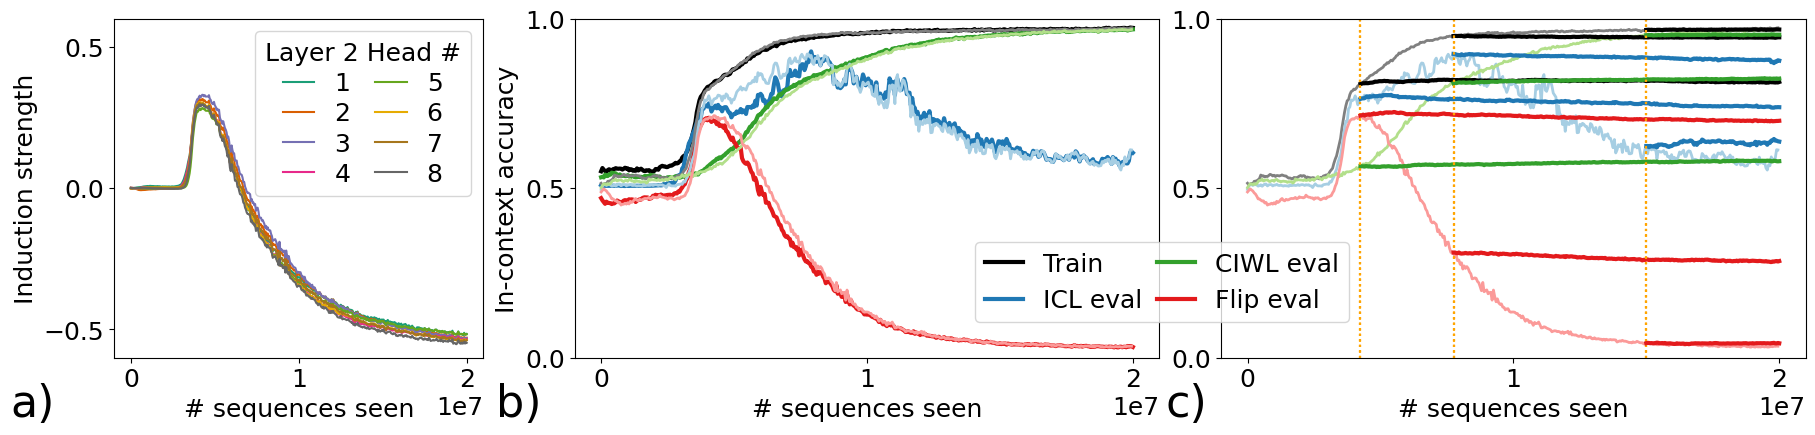

In [33]:
fig, axs = plt.subplots(1,3,sharex=True,width_ratios=[0.24, 0.38, 0.38],
                        constrained_layout=True, squeeze=False)
fig.set_size_inches(18,4.2)
plot_row = 0

cmap = plt.get_cmap('Dark2')
activations = jnp.transpose(jnp.stack(default_results['avg_attention_over_time']['activations']), (3,2,1,0))
for h in range(activations.shape[1]):
    correct_activations = activations[2*flip_icl_only_data['correct_ind']+1, h, np.arange(activations.shape[2]), :]
    incorrect_activations = activations[2*(1-flip_icl_only_data['correct_ind'])+1, h, np.arange(activations.shape[2]), :]
    axs[plot_row, 0].plot(default_results['avg_attention_over_time']['iters'], np.mean(correct_activations-incorrect_activations, axis=0), 
                color=cmap(h), label=h+1)
axs[plot_row, 0].set_ylim(-0.6, 0.6)
axs[plot_row, 0].set_yticks([-0.5, 0, 0.5])
axs[plot_row, 0].set_xlabel('# sequences seen')
axs[plot_row, 0].set_ylabel('Induction strength')
axs[plot_row, 0].legend(title='Layer 2 Head #', 
                          handlelength=1.25, labelspacing=0.25, columnspacing=1, 
                          loc='upper right', ncol=2)

metric='in_context_acc'

name = 'vis_end'
for e in evaluator_info:
    ind = all_data['metadata_labels'].index('_' + e) # _ gets inserted in visualize runs
    mask = all_data['metadata_ind'] == ind
    x = np.array(results_l1[name]['metric_by_color_by']['iters'])
    vals = jnp.mean(jnp.stack(results_l1[name]['metric_by_color_by'][metric])[:, mask], axis=1)
    ckpt_ind = int(ckpts_to_graft_l1[name][:-4])
    xmask = x <= vis_end
    axs[plot_row, 1].plot(x[xmask], vals[xmask], lw=3, ls='-', **evaluator_info[e])

axs[plot_row, 1].set_ylim(0,1)
axs[plot_row, 1].set_ylabel('In-context accuracy')
axs[plot_row, 1].set_xlabel('# sequences seen')
axs[plot_row, 1].set_yticks([0, 0.5, 1.0])

fig.legend(*axs[plot_row, 1].get_legend_handles_labels(), ncol=2, bbox_to_anchor=(0.64, 0.34), loc='center',
            columnspacing=0.6, handlelength=1.5)

f = h5.File(f'{base_folder}/{main_run}/log.h5', 'r')
base_x = f['eval_iter'][:]
vis_end = 2e7
base_mask = base_x < vis_end

for e in evaluator_info:
    axs[plot_row, 1].plot(base_x[base_mask], np.mean(f[e][metric][base_mask, :], axis=1), lw=2, 
                 c = lighter_colors[evaluator_info[e]['c']])
    axs[plot_row, 2].plot(base_x[base_mask], np.mean(f[e][metric][base_mask, :], axis=1), lw=2, 
                 label=evaluator_info[e]['label'], c = lighter_colors[evaluator_info[e]['c']])
f.close()

for i, name in enumerate(['2', '3.5', '4']):
    for e in evaluator_info:
        ind = all_data['metadata_labels'].index('_' + e) # _ gets inserted in visualize runs
        mask = all_data['metadata_ind'] == ind
        x = np.array(results_l0[name]['metric_by_color_by']['iters'])
        vals = jnp.mean(jnp.stack(results_l0[name]['metric_by_color_by'][metric])[:, mask], axis=1)
        ckpt_ind = int(ckpts_to_graft_l0[name][:-4])
        xmask = np.logical_and(x <= vis_end, x >= ckpt_ind)

        axs[plot_row, 2].axvline(ckpt_ind, color='orange', ls='dotted')
        axs[plot_row, 2].plot(x[xmask], vals[xmask], lw=3, c=evaluator_info[e]['c'])
axs[plot_row, 2].set_ylim(0,1)
axs[plot_row, 2].set_yticks([0, 0.5, 1.0])
axs[plot_row, 2].set_xlabel('# sequences seen')

fig.text(0, 0, 'a)', ha='left', va='bottom', fontsize=32)
fig.text(0.27, 0, 'b)', ha='left', va='bottom', fontsize=32)
fig.text(0.642, 0, 'c)', ha='left', va='bottom', fontsize=32)

fig.savefig(f'{save_folder}/figure_3v4.pdf')

## Section 5.2-5

In the next plot, we show evidence of the cooperative interactions. We'll have 3 subpanels:

1. Loss when training on ICL data. Two lines: one where training from scratch, one when using second half weights from end of training on bursty data ("converged" cIWL solution)
2. Loss on ICL only data when training on ICL only data from different L2 weights of a cIWL run. Color code using viridis or something to show which checkpoint the L2 weights are from.
3. Performance on flip eval as a function of resuming from different checkpoints of a cIWL run. Plot the underlying CIWL run for reference. Share the color bar for plots b and c.


In [34]:
clamp_runs = {4:    'icl_only_graftl1_from_ciwl_only_4M',
              8:    'icl_only_graftl1_from_ciwl_only_8M',
              9.75: 'icl_only_graftl1_from_ciwl_only_9.75M',
              # Start of window
              9.8:  'icl_only_graftl1_from_ciwl_only_9.8M',
              15:   'icl_only_graftl1_from_ciwl_only_15M',
              20:   'icl_only_graftl1_from_ciwl_only_20M',
              25:   'icl_only_graftl1_from_ciwl_only_25M',
              31.5: 'icl_only_graftl1_from_ciwl_only_31.5M',
              # End of window
              32:   'icl_only_graftl1_from_ciwl_only_32M',
              48:   'icl_only_graftl1_from_ciwl_only_48M',
              64:   'icl_only_graftl1_from_ciwl_only_64M'
             }

resume_runs = {4:    'init_from_ciwl_only_4M',
               5:    'init_from_ciwl_only_5M',
               6:    'init_from_ciwl_only_6M',
               7:    'init_from_ciwl_only_7M',
               8:    'init_from_ciwl_only_8M',
               9:    'init_from_ciwl_only_9M',
               10:   'init_from_ciwl_only_10M',
               12:   'init_from_ciwl_only_12M',
               16:   'init_from_ciwl_only_16M',
              }

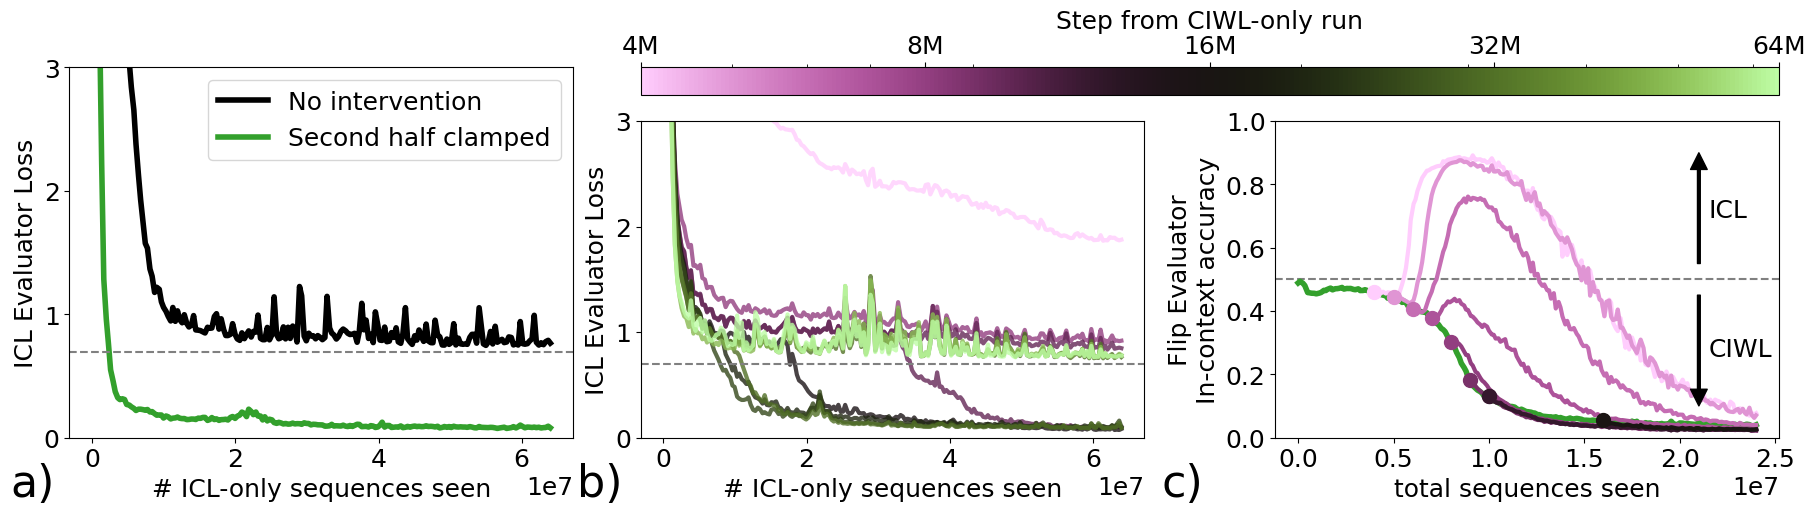

In [35]:
legend_row = 0
plot_row = 1 - legend_row
ratios = [1,1]
ratios[legend_row] = 0.08
ratios[plot_row] = 1-ratios[legend_row]
fig, axs = plt.subplots(2, 3,
                        height_ratios=ratios,
                        constrained_layout=True, squeeze=False)
fig.set_size_inches(18,5)

for ax in axs[:, 0]:
  ax.remove()
left_ax = fig.add_subplot(axs[plot_row,-1].get_gridspec()[:, 0])

first_xlim = 6.4e7
to_plot = np.linspace(0, first_xlim, 200)

metric = 'loss'
f = h5.File(f'{base_folder}/icl_only/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
left_ax.plot(raw_x[mask], np.mean(f['icl'][metric][mask, :], axis=1), lw=lw,
                c = 'k', label='No intervention')
f.close()

f = h5.File(f'{base_folder}/icl_only_graftl1/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
left_ax.plot(raw_x[mask], np.mean(f['icl'][metric][mask, :], axis=1), lw=lw,
                c = evaluator_info['iwl_copy_avail']['c'], label='Second half clamped')
f.close()

left_ax.axhline(np.log(2), c='gray', ls='--')
left_ax.legend()
left_ax.set_ylim(0, 3)
left_ax.set_yticks([0,1,2,3])
left_ax.set_ylabel('ICL Evaluator Loss')
left_ax.set_xlabel('# ICL-only sequences seen')

norm = mcolors.LogNorm(vmin=4, vmax=64)
cmap = plt.get_cmap('vanimo')

axs[legend_row, 1].remove()
axs[legend_row, 2].remove()

colorbar_ax = fig.add_subplot(axs[plot_row,-1].get_gridspec()[legend_row, 1:])

ticks = [4,8,16,32,64]
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                     cax=colorbar_ax, label='Step from CIWL-only run',
                     ticks=ticks,
                     location='top')
cbar.ax.set_xticklabels(['{}M'.format(t) for t in ticks])
##

for run in clamp_runs:
    f = h5.File(f'{base_folder}/{clamp_runs[run]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    axs[plot_row,1].plot(raw_x[mask], np.mean(f['icl'][metric][mask, :], axis=1), lw=3,
                    c = cmap(norm(run)), label=run, alpha=0.8)
    f.close()
axs[plot_row,1].axhline(np.log(2), c='gray', ls='--')

axs[plot_row,1].set_ylim(0, 3)
axs[plot_row,1].set_yticks([0,1,2,3])
axs[plot_row,1].set_ylabel('ICL Evaluator Loss')
axs[plot_row,1].set_xlabel('# ICL-only sequences seen')

metric = 'in_context_acc'
second_xlim = 2.4e7
to_plot = np.linspace(0, second_xlim, 200)

axs[plot_row,2].axhline(0.5, c='gray', ls='--')
f = h5.File(f'{base_folder}/ciwl_only/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = visualize_runs.get_closest_inds(to_plot, raw_x)
axs[plot_row,2].plot(raw_x[mask], np.mean(f['flip_icl'][metric][mask, :], axis=1), lw=lw,
                c = evaluator_info['iwl_copy_avail']['c'], label='CIWL-only run')
f.close()

for run in resume_runs:
    f = h5.File(f'{base_folder}/{resume_runs[run]}/log.h5', 'r')
    raw_x = f['eval_iter'][:]
    mask = visualize_runs.get_closest_inds(to_plot, raw_x)
    axs[plot_row,2].plot(raw_x[0], np.mean(f['flip_icl'][metric][0]), c=cmap(norm(run)), marker='o', markersize=10)
    axs[plot_row,2].plot(raw_x[mask], np.mean(f['flip_icl'][metric][mask, :], axis=1), lw=3,
                    c = cmap(norm(run)), label=run)
    f.close()

axs[plot_row,2].set_ylabel('Flip Evaluator\nIn-context accuracy')
axs[plot_row,2].set_ylim(0, 1)
axs[plot_row,2].set_xlabel('total sequences seen')
axs[plot_row,2].annotate('', xy=(2.1e7, 0.9), xytext=(2.1e7, 0.55),
                            arrowprops=dict(facecolor='black', shrink=0, width=2))
axs[plot_row,2].text(2.15e7, 0.72, 'ICL', va='center')

axs[plot_row,2].annotate('', xy=(2.1e7, 0.1), xytext=(2.1e7, 0.45),
                            arrowprops=dict(facecolor='black', shrink=0, width=2))
axs[plot_row,2].text(2.15e7, 0.28, 'CIWL', va='center')

fig.text(0, 0, 'a)', ha='left', va='bottom', fontsize=32)
fig.text(0.315, 0, 'b)', ha='left', va='bottom', fontsize=32)
fig.text(0.64, 0, 'c)', ha='left', va='bottom', fontsize=32)

fig.savefig(f'{save_folder}/figure_4v3.pdf')

# Section 6

This section focuses on the toy model, and the loss divots we observe.

In [36]:
toy_model_loss = coopetition_model_solver.make_4share2_loss_fn(alpha=0.1, mu1=0.1)
toy_model_setup = coopetition_model_solver.make_rank_1_vecs_setup(**toy_model_loss, dims=[20,20,20,160], seed=7)
toy_model_results = coopetition_model_solver.train(toy_model_setup, max_iters=16000, thresh=1e-6)

  0%|          | 0/16000 [00:00<?, ?it/s]

Terminating early since loss below threshold at iter 9620


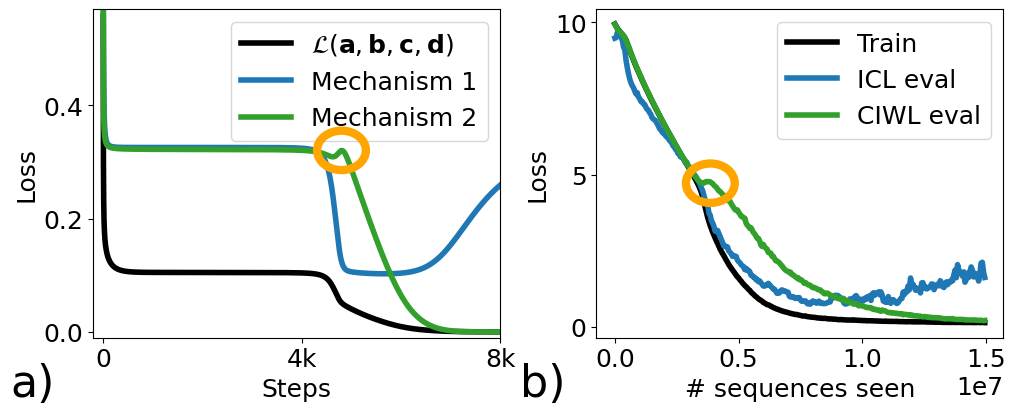

In [37]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,2, constrained_layout=True, squeeze=False)
fig.set_size_inches(10,4)
lw=4

mechanism_info = {'Train loss': {'offset': 0, 'c': evaluator_info['train_eval']['c'], 
                                 'label': r'$\mathcal{L}(\mathbf{a}, \mathbf{b}, \mathbf{c}, \mathbf{d})$'},
                  'Mechanism 1 loss': {'offset': 0.1, 'c': evaluator_info['icl']['c'], 'label': 'Mechanism 1'},
                  'Mechanism 2 loss': {'offset': 0, 'c': evaluator_info['iwl_copy_avail']['c'], 'label': 'Mechanism 2'}
                 }
lim = 0
for l in ['Train loss', 'Mechanism 1 loss', 'Mechanism 2 loss']:
    axs[0,0].plot(np.array(toy_model_results[l])+mechanism_info[l]['offset'], 
                  label=mechanism_info[l]['label'], c = mechanism_info[l]['c'], lw=lw)
    lim = max(lim, toy_model_results[l][-1])
axs[0,0].set_ylim(-0.01,0.57)
axs[0,0].set_xlim(-200, 8000)
axs[0,0].set_xticks([0, 4000, 8000], ['0', '4k', '8k'])
axs[0,0].set_yticks([0, 0.2, 0.4])
axs[0,0].set_xlabel('Steps')
axs[0,0].legend()
axs[0,0].set_ylabel('Loss')

circle = plt.Circle((0.61, 0.57), 0.06, color=annot_color, lw=lw+2, 
                    fill=False, transform=axs[0,0].transAxes, zorder=100)
axs[0,0].add_artist(circle)

f = h5.File(f'{base_folder}/{main_run}/log.h5', 'r')
metric='loss'
raw_x = f['eval_iter'][:]
mask = raw_x < 1.5e7
for e in ['train_eval', 'icl', 'iwl_copy_avail']:
    axs[0,1].plot(raw_x[mask], np.mean(f[e][metric][mask, :], axis=1), lw=lw, **evaluator_info[e])

axs[0,1].legend()
axs[0,1].set_ylabel("Loss")
axs[0,1].set_xlabel("# sequences seen")
axs[0,1].set_yticks([0, 5, 10])

circle = plt.Circle((0.28, 0.47), 0.06, color=annot_color, lw=lw+2, 
                    fill=False, transform=axs[0,1].transAxes, zorder=100)
axs[0,1].add_artist(circle)
f.close()

fig.text(0, 0, 'a)', ha='left', va='bottom', fontsize=32)
fig.text(0.51, 0, 'b)', ha='left', va='bottom', fontsize=32)
fig.savefig(f'{save_folder}/figure_5v1.pdf')

# Section 7

Plots on matching exemplar data vs normal.

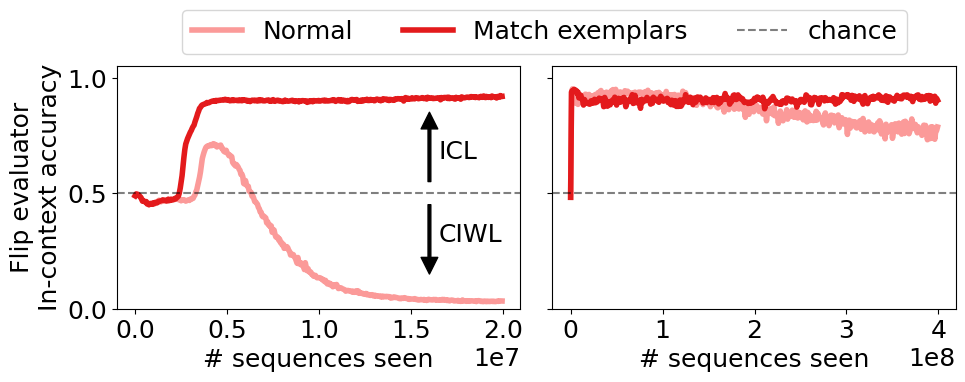

In [38]:
matplotlib.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1,2, squeeze=False, sharey=True)
fig.set_size_inches(10, 4)
lw=4
metric='in_context_acc'

small_xlim = 2e7

f = h5.File(f'{base_folder}/{main_run}/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = raw_x < small_xlim
axs[0,0].plot(raw_x[mask], np.mean(f['flip_icl'][metric][mask, :], axis=1), lw=lw,
                c = lighter_colors[evaluator_info['flip_icl']['c']], label='Normal')
f.close()

f = h5.File(f'{base_folder}/mq/log.h5', 'r')
raw_x = f['eval_iter'][:]
y_to_use = f['flip_icl'][metric][np.where(raw_x == 0)[0][-1]:]
raw_x = raw_x[np.where(raw_x == 0)[0][-1]:]
mask = raw_x < small_xlim
axs[0,0].plot(raw_x[mask], np.mean(y_to_use[mask, :], axis=1), lw=lw, 
                c = evaluator_info['flip_icl']['c'], label='Match exemplars')
f.close()

axs[0,0].annotate('', xy=(1.6e7, 0.85), xytext=(1.6e7, 0.55),
                    arrowprops=dict(facecolor='black', shrink=0, width=2))
axs[0,0].text(1.65e7, 0.68, 'ICL', va='center')

axs[0,0].annotate('', xy=(1.6e7, 0.15), xytext=(1.6e7, 0.45),
                    arrowprops=dict(facecolor='black', shrink=0, width=2))
axs[0,0].text(1.65e7, 0.32, 'CIWL', va='center')

# The plot in the paper shows 2.9e8 since the run crashed
big_xlim = 4e8 

f = h5.File(f'{base_folder}/12l/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = raw_x < big_xlim
axs[0,1].plot(raw_x[mask], np.mean(f['flip_icl'][metric][mask, :], axis=1), lw=lw, 
                c = lighter_colors[evaluator_info['flip_icl']['c']], label='Normal')
f.close()

f = h5.File(f'{base_folder}/12l_mq/log.h5', 'r')
raw_x = f['eval_iter'][:]
mask = raw_x < big_xlim
axs[0,1].plot(raw_x[mask], np.mean(f['flip_icl'][metric][mask, :], axis=1), lw=lw, 
                c = evaluator_info['flip_icl']['c'], label='Match exemplars')
f.close()

axs[0,0].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
axs[0,1].axhline(0.5, c='k', ls='--', label='chance', alpha=0.5)
axs[0,0].set_ylim(0, 1.05)
axs[0,0].set_ylabel("Flip evaluator\nIn-context accuracy")
axs[0,0].set_xlabel("# sequences seen")
axs[0,1].set_xlabel("# sequences seen")
plt.tight_layout(rect=(0,0,1,0.9))

axs[0,0].legend(bbox_to_anchor=(1.06, 1), loc='lower center', ncols=3)

fig.savefig(f'{save_folder}/figure_6v2.pdf')
